In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch

import flippers

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
# This helper loads any dataset in the wrench benchmarks
# and creates monopolar label matrices from their multipolar data
def load_wrench_dataset(dataset):
    dataset = "datasets/" + f"{dataset}" + "/{}.json"
    train = pd.read_json(dataset.format("train")).T
    dev = pd.read_json(dataset.format("valid")).T
    test = pd.read_json(dataset.format("test")).T

    L_train, polarities, polarities_mapping = flippers.multipolar_to_monopolar(
        train["weak_labels"].apply(pd.Series)
    )
    L_dev, _, _ = flippers.multipolar_to_monopolar(
        dev["weak_labels"].apply(pd.Series), polarities_mapping
    )
    L_test, _, _ = flippers.multipolar_to_monopolar(
        test["weak_labels"].apply(pd.Series), polarities_mapping
    )

    return (train, dev, test), (L_train, L_dev, L_test), polarities

Choose your dataset here

In [6]:
dataset = "cdr"
# dataset = "census"
# dataset = "yelp"
# dataset = "youtube"
# dataset= "semeval"
# dataset = "spouse"


data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

C:\Users\liamt\Repos\flippers\flippers\_core\_core.py:132: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [7]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.6673913043478261, 0.33260869565217394]

# Brief overview of `flippers`

The following is the weak label matrix binary format used by `flippers`.

All labeling functions are unimodal, either predicting 0 ("Abstain") or a 1.

This is different than some other weak supervision libraries like Snorkel, where Abstains are -1, and other outputs are polarized predictions.

In [8]:
L_train

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8425,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8426,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8427,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8428,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


The polarity of a labeling function informs which class it is trying to detect.

We have `#|weak labelers| = L.shape[1] = len(polarities)`

In [9]:
polarities

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [10]:
flippers.summary(L_train, polarities)

,polarity,coverage,confidence,overlaps,matched,conflicted
0,1,0.032,1.0,0.028,0.026,0.013
1,1,0.022,1.0,0.018,0.018,0.006
2,1,0.004,1.0,0.004,0.004,0.002
3,0,0.048,1.0,0.048,0.048,0.020
4,0,0.088,1.0,0.087,0.087,0.038
5,0,0.188,1.0,0.170,0.145,0.092
6,0,0.014,1.0,0.014,0.013,0.009
7,1,0.018,1.0,0.018,0.018,0.005
8,1,0.020,1.0,0.020,0.020,0.008
9,0,0.047,1.0,0.047,0.047,0.017


Scoring utils:

In [11]:
y_test = test["label"].astype(int).values

In [12]:
Metrics = {}


def score(
    model,
    L=L_test,
    y_true=y_test,
    boxplots=True,
    fill_proba=False,
    name="",
    predict_proba_args={},
):
    y_pred = model.predict_proba(L, *predict_proba_args)[:, 1]

    def fill_proba(proba):
        proba = proba.copy()
        proba[L.sum(axis=1) == 0] = class_balances[1]
        return proba

    if fill_proba:
        y_pred = fill_proba(y_pred)

    AP = metrics.average_precision_score(y_true, y_pred)
    F1 = metrics.f1_score(y_true, y_pred.round())
    AUC = metrics.roc_auc_score(y_true, y_pred)
    Accuracy = metrics.accuracy_score(y_true, y_pred.round())
    Balanced_Accuracy = metrics.balanced_accuracy_score(y_true, y_pred.round())
    M = {
        "F1": F1,
        "Average_Precision": AP,
        "AUC": AUC,
        "Accuracy": Accuracy,
        "Balanced_Accuracy": Balanced_Accuracy,
    }
    for key in M:
        M[key] = round(M[key], 3)

    if boxplots:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))
        plt.title(name)
        pd.DataFrame({"y_pred": y_pred, "y_true": y_true}).boxplot(
            by="y_true", ax=axs[0]
        )
        axs[0].set_title("Predicted probabilities grouped by ground truth")
        axs[0].set_ylim([0, 1])
        axs[0].get_figure().suptitle("")
        plt.ylabel("y_pred")

        pd.Series(y_pred).plot.box(ax=axs[1])
        axs[1].set_title("Predicted probabilties")
        axs[1].set_ylim([0, 1])
        axs[1].axhline(
            y_true.mean(), color="g", linestyle="--", alpha=0.3, label="Mean of y_true"
        )

        # Add a cross indicating the mean of y_pred
        mean_y_pred = pd.Series(y_pred).mean()
        axs[1].scatter(
            [1], [mean_y_pred], marker="+", color="r", s=200, label="Mean of y_pred"
        )
        axs[1].legend()

        plt.ylabel("y_pred")
        plt.tight_layout()
        plt.show()
    if name:
        global Metrics
        Metrics[name] = M
    return M

# Training Label Models

## Majority Vote Model

In [13]:
from flippers.models import Voter

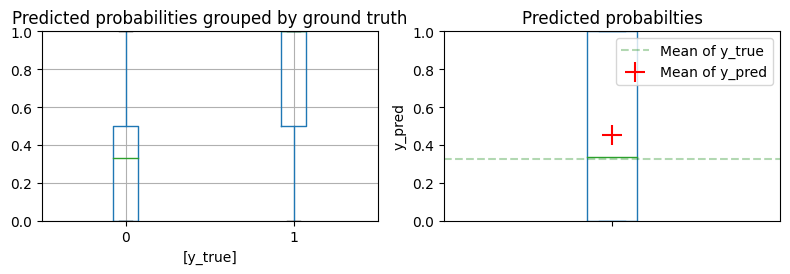

{'F1': 0.613,
 'Average_Precision': 0.586,
 'AUC': 0.821,
 'Accuracy': 0.753,
 'Balanced_Accuracy': 0.714}

In [14]:
preds_vote = Voter(polarities)
score(preds_vote, name="MV")

## `flippers`' Snorkel Model

Training a Label Model with Flippers is very simple:

In [15]:
from flippers.models import SnorkelModel

In [16]:
m = SnorkelModel(polarities=polarities, class_balances=class_balances)
m.fit(L_train, learning_rate=5e-3)

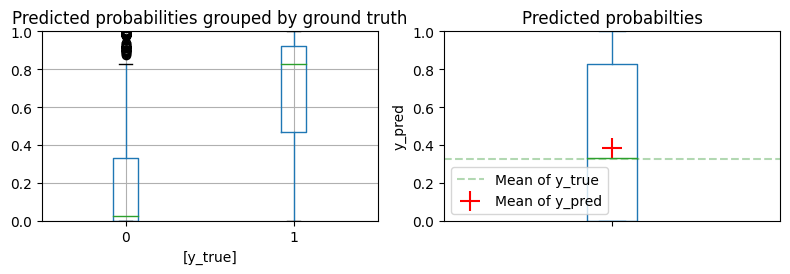

{'F1': 0.689,
 'Average_Precision': 0.655,
 'AUC': 0.842,
 'Accuracy': 0.791,
 'Balanced_Accuracy': 0.771}

In [17]:
# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
score(m, name="flippers")